# Translation with **Multiple** Input Images

This notebook calculates the metrics of FID and $L_1$ distance for CollaGAN in the scenarios of it receiving 3, 2 and 1 images as input.

It also compares the replacer strategy (of dropout and forward) and the amount of input dropout to apply during training.

In [1]:
%reset -f

import itertools
%matplotlib inline

In [2]:
import logging_utils
import logging
import tensorflow as tf

print(tf.__version__)
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
    )


from ModelProxy import CollaGANModelProxy, RemicModelProxy

logging_utils.configure(logging.INFO)

should_post_process = False

model_loaders = {
    "CollaGAN": lambda: CollaGANModelProxy("models/collagan", post_process=should_post_process),
    "ReMIC": lambda: RemicModelProxy("models/remic", post_process=should_post_process),

    # Used for CollaGAN's model selection regarding input dropout, and the ablation study:
    #
    # 'IDNone,Forward': lambda: CollaGANModelProxy('models/selection/collagan/replacer-forward-240k/input-dropout-no', post_process=should_post_process),
    # 'IDOrig,Forward': lambda: CollaGANModelProxy('models/collagan/replacer-forward-240k/input-dropout-original', post_process=should_post_process),
    # 'IDCurr,Forward': lambda: CollaGANModelProxy('models/collagan/replacer-forward-240k/input-dropout-curriculum', post_process=should_post_process),
    # 'IDCons,Forward': lambda: CollaGANModelProxy(
    #     'models/model-selection/collagan/replacer-forward-240k/input-dropout-conservative', post_process=should_post_process),
    # 'IDOrig,Dropout': lambda: CollaGANModelProxy('models/collagan/replacer-dropout-240k/input-dropout-original', post_process=should_post_process),
    # 'Capacity1': lambda: CollaGANModelProxy('models/collagan/replacer-dropout-240k/input-dropout-original-capacity1', post_process=should_post_process),
}


2025-06-03 13:26:39.569103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-03 13:26:39.673495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-03 13:26:39.673774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 13:26:39.831984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 13:26:48.114671: W tensorflow/compiler/tf

2.16.2


2025-06-03 13:27:00.547459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 13:27:01.499308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 13:27:01.499437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 13:27:02.129072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 13:27:02.129231: I external/local_xla/xla/stream_executor

## Loads the Larger Dataset

These tests use the Larger dataset.


In [3]:
from dataset_utils import DatasetLoader
from image_utils import show_single_image


dataset_loader = DatasetLoader("all", "test", limit=None)


### Sanity Checks the Dataset

Uncomment the last line below to see a sample image from the dataset.

In [4]:
def show_dataset_image():
    back, left, front, right = next(iter(dataset_loader.dataset))
    show_single_image(front)
    
# show_dataset_image()

## Sanity Checking the Models

Uncomment the last line to see some images generated by each model.


2025-06-03 13:27:15.518149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 555 of 600
2025-06-03 13:27:16.060513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-06-03 13:27:30 INFO     Fingerprint not found. Saved model loading will continue.
2025-06-03 13:27:30 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-06-03 13:27:33.822315: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-06-03 13:27:38.739324: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-03 13:27:39.489045: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator 

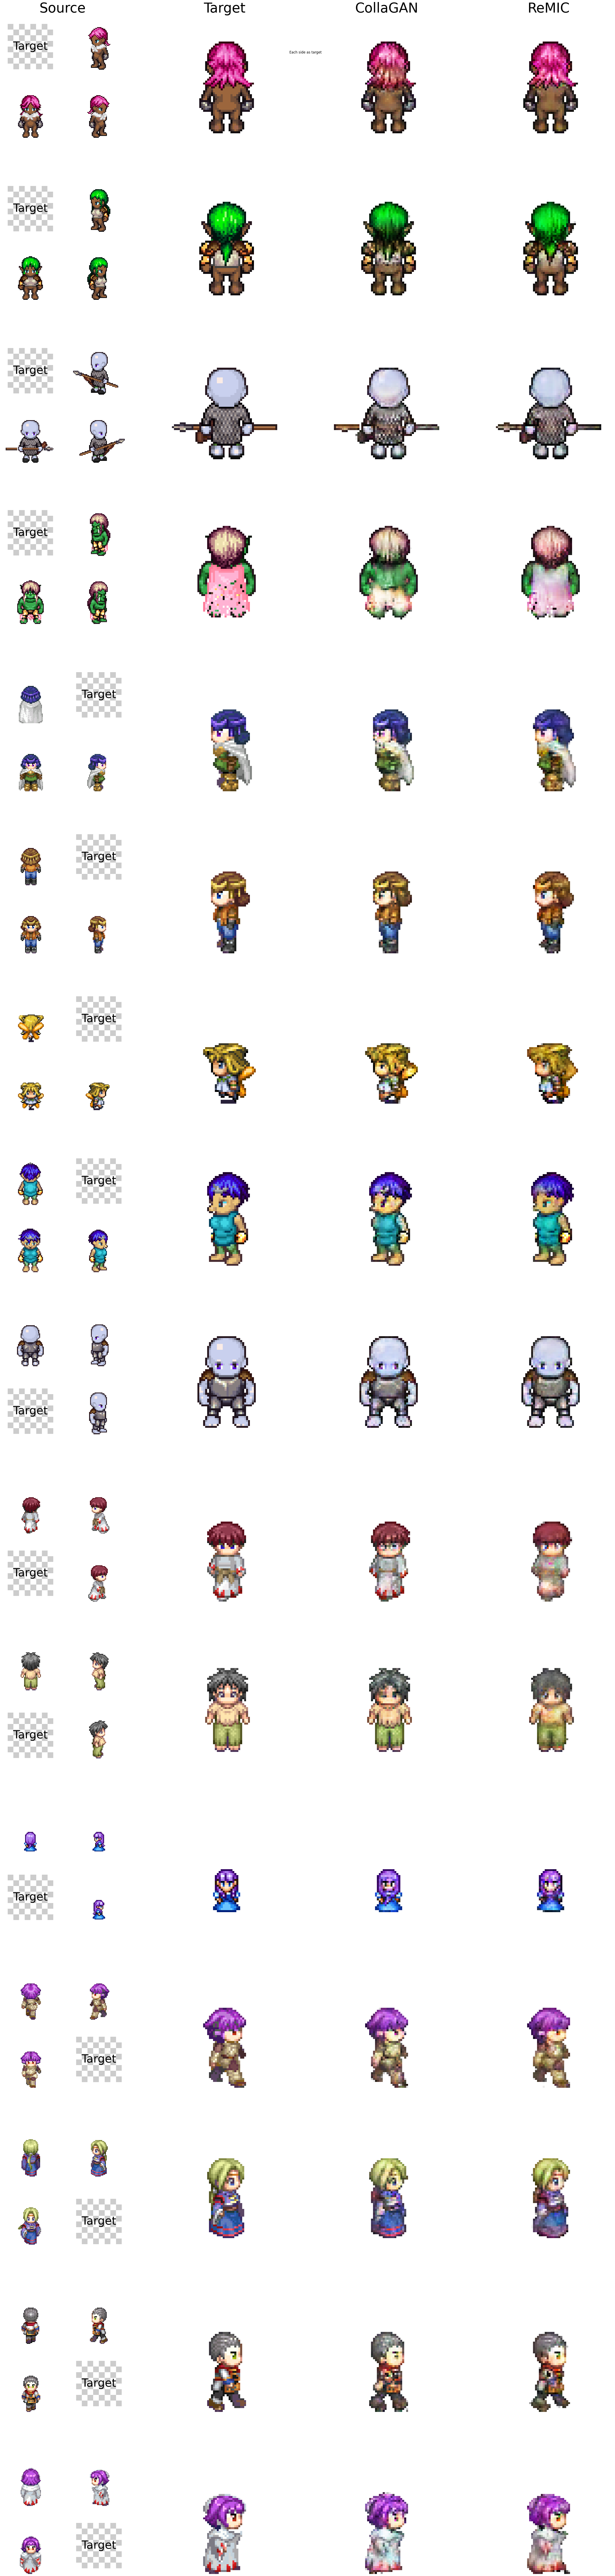

In [5]:
from image_utils import show_multiple_input_model_comparison
import tensorflow as tf

def generate_batch_with_each_model(number_of_4batches=1):
    # loads a batch of images
    batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_4batches*4).take(1)))
    batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
    
    genned_images = []    
    target_indices = (tf.repeat(tf.range(0, 4), [number_of_4batches] * 4))
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
    source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    model_names = list(model_loaders.keys())
    for _, loader in model_loaders.items():
        # loads the model into memory
        generator = loader()    
        # generates the images
        fake_images = generator.generate_from_multiple(target_indices, source_images)
        # shows the images
        genned_images += [fake_images]
        # frees the memory used by the model
        del generator

    show_multiple_input_model_comparison(source_images, target_images, genned_images, f"Each side as target", model_names)

generate_batch_with_each_model(4)


## Running the Metrics Calculcation


In [6]:
import numpy as np
import logging
from itertools import combinations
import evaluation_metrics

DOMAINS = ["back", "left", "front", "right"]
abbreviate_domain_list = lambda domains: "+".join(map(lambda d: d[0], domains))

sanity_sample = dataset_loader.load_paired_images(240)

def calculate_metrics_with_a_single_generator(model_name):
    minimum_inputs = 1
    maximum_inputs = len(DOMAINS) - 1
    
    metrics = {
        target_domain_name: {
            f"Missing {maximum_inputs - available_inputs + 1}": {
                abbreviate_domain_list(combination): [None, None]
                for combination in combinations(DOMAINS, available_inputs) if target_domain_name not in combination
            } for available_inputs in range(minimum_inputs, maximum_inputs + 1)        
        } for target_domain_name in DOMAINS
    }
    
    selected_loader = model_loaders[model_name]
    generator = selected_loader()
    sanity_checked = False    
    
    # batch_size = 178    # for capacity-2, 178 works
    batch_size = 64
    logging.info(f"Start >> Processing model {model_name}")
    for t, target_domain in enumerate(DOMAINS):
        # determines the target images
        logging.info(f"Start >> Processing target {target_domain.upper()}")
        
        # gets the metrics for the target images only once, to speed up
        logging.debug(f"Start >> Calculating FID partial metrics for target {target_domain.upper()}")
        real_images = np.stack(list(dataset_loader.dataset))
        real_images = real_images[:, t]
        real_images_metrics = evaluation_metrics.calculate_metrics_for_dataset(real_images, batch_size)
        logging.debug(f"End   >> Calculating FID partial metrics for target {target_domain.upper()}")
        
        total_combinations_for_target = sum([sum(1 for ignore in combinations(DOMAINS, inputs)) for inputs in range(minimum_inputs, maximum_inputs + 1)]) // 2
        combination_for_target_index = 0
        get_progress = lambda: f"{combination_for_target_index}/{total_combinations_for_target}"
        
        for available_inputs in range(maximum_inputs, minimum_inputs - 1, -1):
        #for available_inputs in [1]:
            missing_inputs = maximum_inputs - available_inputs + 1
            possible_input_combinations = list(combinations(DOMAINS, available_inputs))
            logging.debug(f"Start >> Processing {missing_inputs} missing input(s)")
            
            for input_combination in possible_input_combinations:
                abbreviated_source_domains = abbreviate_domain_list(input_combination)
                logging.debug(f"Start >> input combination: {abbreviated_source_domains}")
                if target_domain in input_combination:
                    continue
                
                # determines the input images from the source domains
                input_keep_mask = [1 if d in input_combination else 0 for d in DOMAINS]
                logging.debug(f"input_combination is {input_combination} and input_keep_mask is {input_keep_mask}")
                input_keep_mask = tf.constant(input_keep_mask, dtype=tf.float32)[tf.newaxis, :, tf.newaxis, tf.newaxis, tf.newaxis]
                
                # generates the images
                logging.info(f"Start >> Generating images {abbreviated_source_domains}-to-{target_domain} ({get_progress()})")
                # if not sanity_checked:
                #     # sanity_checked = True
                #     sanity_sample_dropped_out = sanity_sample * input_keep_mask
                #     sanity_generated = generator.generate_from_multiple(tf.expand_dims(t, 0), sanity_sample_dropped_out)
                #     fig = show_multiple_input_model_comparison(sanity_sample_dropped_out, tf.expand_dims(sanity_sample[t], 0), sanity_generated[tf.newaxis, ...], f"Sanity check {abbreviated_source_domains}-to-{target_domain}")
                #     fig.savefig(f"sample-outputs/{model_name},{abbreviated_source_domains}-to-{target_domain}.png", transparent=True)
                
                fake_images = []
                batched_dataset = dataset_loader.dataset.batch(batch_size)
                for batch_number, batch in batched_dataset.enumerate():
                    logging.debug(f"Start >> Generating batch {batch_number}")
                    batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
                    batch_transpose_dropped_out = batch_transpose * input_keep_mask
                    target_input = tf.repeat(tf.constant([t]), len(batch_transpose))
                    generated_images = generator.generate_from_multiple(target_input, batch_transpose_dropped_out)
                    fake_images.append(generated_images.numpy())
                    logging.debug(f"End   >> Generating batch {batch_number}")               

                # calculates the metrics
                fake_images = np.concatenate(fake_images, axis=0)
                fake_images_metrics = evaluation_metrics.calculate_metrics_for_dataset(fake_images)
                fid = evaluation_metrics.calculate_fid(real_images_metrics, fake_images_metrics)
                l1 = evaluation_metrics.calculate_l1(real_images, fake_images)
                metrics[target_domain][f"Missing {missing_inputs}"][abbreviated_source_domains] = [fid, l1.numpy()]
                
                combination_for_target_index += 1
                logging.info(f"End   >> Generating images {abbreviated_source_domains}-to-{target_domain} ({get_progress()})")
                    
            logging.debug(f"End   >> Processing {missing_inputs} missing input(s)")
            
        logging.info(f"End   >> Processing target {target_domain.upper()}")
    
    logging.info(f"End   >> Processing model {model_name}")
    del generator
    return metrics

resulting_metrics = {
    # "collagan,inpdrop-aggressive,rep-forward": calculate_metrics_with_a_single_generator("collagan,inpdrop-aggressive,rep-forward")
}

In [7]:
import pandas as pd

def generate_table_from_single_model(metrics):
    df = pd.DataFrame(columns=["Missing", "Source", "Target", "FID", "L1"])
    for target_domain, target_metrics in metrics.items():
        for missing_text, missing_metrics in target_metrics.items():
            for abbreviated_source_domains, values in missing_metrics.items():
                df = pd.concat([df if not df.empty else None, pd.DataFrame({
                    "Missing": [missing_text],
                    "Source": [abbreviated_source_domains],
                    "Target": [target_domain],
                    "FID": [values[0] or ""],
                    "L1": [values[1] or ""]
                })], ignore_index=True)
                
    return df
            
# generate_table_from_single_model(resulting_metrics["collagan,inpdrop-aggressive,rep-forward"])

## Calculates the Metrics for All Models

Calculate the metrics for all models.


In [8]:
from tqdm import tqdm

for model_name, model_loader in tqdm(model_loaders.items(), desc="Models", total=len(model_loaders) - len(resulting_metrics)):
    if model_name not in resulting_metrics:
        resulting_metrics[model_name] = calculate_metrics_with_a_single_generator(model_name)


Models:   0%|          | 0/2 [00:00<?, ?it/s]2025-06-03 13:28:18 INFO     Fingerprint not found. Saved model loading will continue.
2025-06-03 13:28:18 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-06-03 13:28:18 INFO     Start >> Processing model CollaGAN
2025-06-03 13:28:18 INFO     Start >> Processing target BACK
2025-06-03 13:28:43.336979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-03 13:28:45 INFO     Start >> Loading InceptionV3 model...
2025-06-03 13:28:51 INFO     End   >> Loading InceptionV3 model.
I0000 00:00:1748968135.269423  367815 service.cc:145] XLA service 0x79191a030d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748968135.269753  367815 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-06-03 13:28:55.842267: I tensorflow/c

In [9]:
from datetime import datetime


def generate_table_from_all_models(metrics):
    model_dfs = [generate_table_from_single_model(m) for m in metrics.values()]
    df = pd.concat(model_dfs, keys=[*metrics.keys()], names=["Model"]).reset_index(level=[0])
    return df

today = datetime.today().strftime("%d-%m-%Y")
metrics_df = generate_table_from_all_models(resulting_metrics)
numeric_cols = ["FID", "L1"]
metrics_df[numeric_cols] = metrics_df[numeric_cols].apply(pd.to_numeric, errors="coerce")
metrics_df.to_excel(f"output/multiple-input-{today}.xlsx", index=False)
metrics_df

,Model,Missing,Source,Target,FID,L1
0,CollaGAN,Missing 3,l,back,16.398737,0.072543
1,CollaGAN,Missing 3,f,back,2.706737,0.049713
2,CollaGAN,Missing 3,r,back,19.116053,0.076301
3,CollaGAN,Missing 2,l+f,back,2.236230,0.046375
4,CollaGAN,Missing 2,l+r,back,13.571868,0.068941
5,CollaGAN,Missing 2,f+r,back,2.601218,0.046073
6,CollaGAN,Missing 1,l+f+r,back,2.053871,0.045303
7,CollaGAN,Missing 3,b,left,8.579978,0.074628
8,CollaGAN,Missing 3,f,left,5.167878,0.069398
9,CollaGAN,Missing 3,r,left,2.157284,0.035160
